In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/tlm-files/tlm/models/now-tlm-2025-08-15_15-08-29/checkpoint-60000/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-11 17:08:28.311383: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 17:08:28.332761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757610508.357777   10917 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757610508.365587   10917 cuda_blas.cc:1407] Unable to 

In [2]:
time_embeddings = []
years = list(range(10, 25))
months = list(range(1, 13))
timetoks = []
for year in years:
    for month in months:
        timetoks.append('[TIME:{i}-{j}]'.format(i=year, j=month))


time_fill_token_ids = [tokenizer.encode(e)[1] for e in timetoks]
# Get the vocab matrix row for each year_fill_token_id
# This is typically the embedding layer's weight matrix
embedding_matrix = model.get_input_embeddings().weight.detach().cpu()
for token_id in time_fill_token_ids:
    time_embeddings.append(embedding_matrix[token_id])

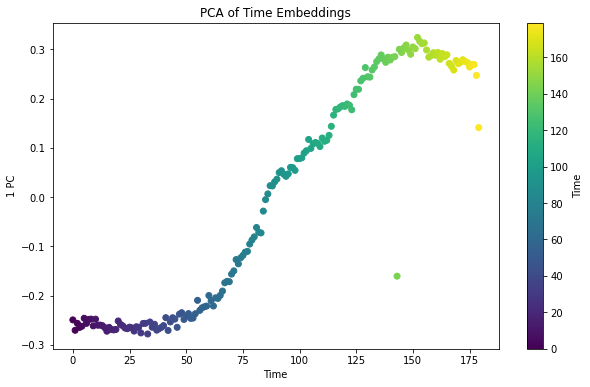

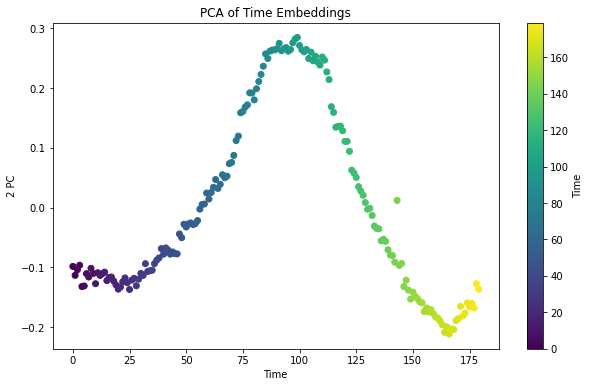

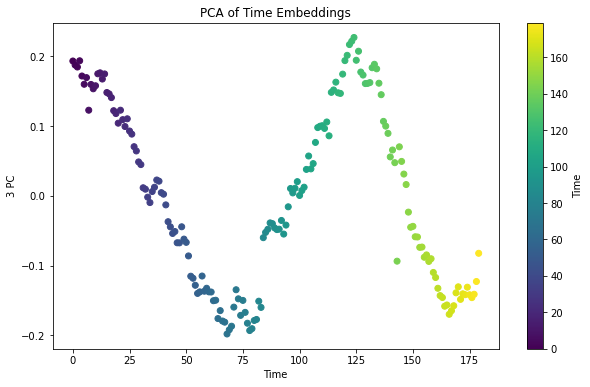

In [6]:
import numpy as np
from matplotlib import pyplot as plt
# Convert to numpy array
time_matrix = np.stack(time_embeddings)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
time_pca = pca.fit_transform(time_matrix)
colors = [j for j, _ in enumerate(timetoks)]
for i in range(3):
    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter([j for j, _ in enumerate(timetoks)], time_pca[:, i], c=colors, cmap='viridis')
    plt.colorbar(label='Time')
    plt.xlabel('Time')
    plt.ylabel('{} PC'.format(i+1))
    plt.title('PCA of Time Embeddings')
    plt.show()

import plotly.graph_objs as go

# Filter for years 2015-2017 (indices 60-95: years 15-17, months 1-12 each)
start_idx = 5 * 12  # year 15 (2015) starts at index 60
end_idx = 8 * 12    # year 18 (2018) starts at index 96, so we want up to 95

filtered_time_pca = time_pca[start_idx:end_idx]
filtered_colors = colors[start_idx:end_idx]
filtered_timetoks = timetoks[start_idx:end_idx]

fig = go.Figure(data=[go.Scatter3d(
    x=filtered_time_pca[:, 0],
    y=filtered_time_pca[:, 1],
    z=filtered_time_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=filtered_colors,
        colorscale='Viridis',
        colorbar=dict(title='Time'),
        opacity=0.8
    ),
    text=[str(timetok) for timetok in filtered_timetoks],
    textposition='top center'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Interactive 3D PCA of Time Embeddings (2015-2017)',
    width=1000,
    height=600
)
fig.show()


In [9]:


import plotly.io as pio

fig = go.Figure(data=[go.Scatter3d(
    x=year_pca[:, 0],
    y=year_pca[:, 1],
    z=year_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=years,
        colorscale='Viridis',
        colorbar=dict(title='Year'),
        opacity=0.8
    ),
    text=[str(year) for year in years],
    textposition='top center'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Interactive 3D PCA of Year Embeddings',
    width=1000,
    height=600
)

# Export the plot as HTML
pio.write_html(fig, file="year_pca_3d.html", auto_open=False)

In [7]:
time_matrix = np.stack([e.numpy() for e in time_embeddings])

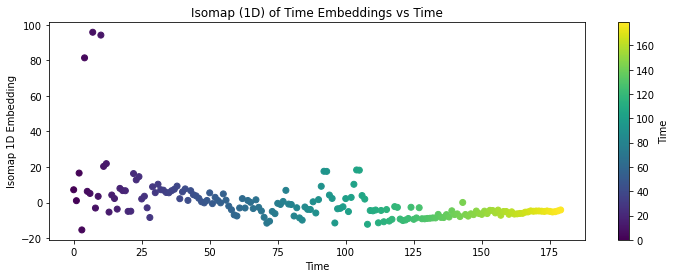

In [9]:
from sklearn.manifold import Isomap

# Assuming year_embeddings is the variable holding the embeddings
isomap = Isomap(n_components=1)
time_isomap_1d = isomap.fit_transform(time_matrix)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.scatter([j for j, _ in enumerate(timetoks)], time_isomap_1d[:, 0], c=colors, cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Isomap 1D Embedding')
plt.title('Isomap (1D) of Time Embeddings vs Time')
plt.colorbar(label='Time')
plt.show()


In [15]:
from scipy.stats import kendalltau

# Flatten the isomap embedding to a 1D array
isomap_1d_flat = year_isomap_1d[:, 0]

# Perform Kendall's tau test between the year order and the isomap order
tau, p_value = kendalltau(years, isomap_1d_flat)

print(f"Kendall's tau correlation between year and Isomap 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


Kendall's tau correlation between year and Isomap 1D embedding: 0.9816
P-value: 3.0480e-28
